In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
import torch.optim as optim

matplotlib Settings

In [ ]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

Methods Definitions

In [ ]:
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')

    return datarec

Variables Definitions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

Prepare Input Files

In [ ]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt
records = list()
annotations = list()
filenames.sort()

In [ ]:
# segregating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

Data Extraction and Preprocessing

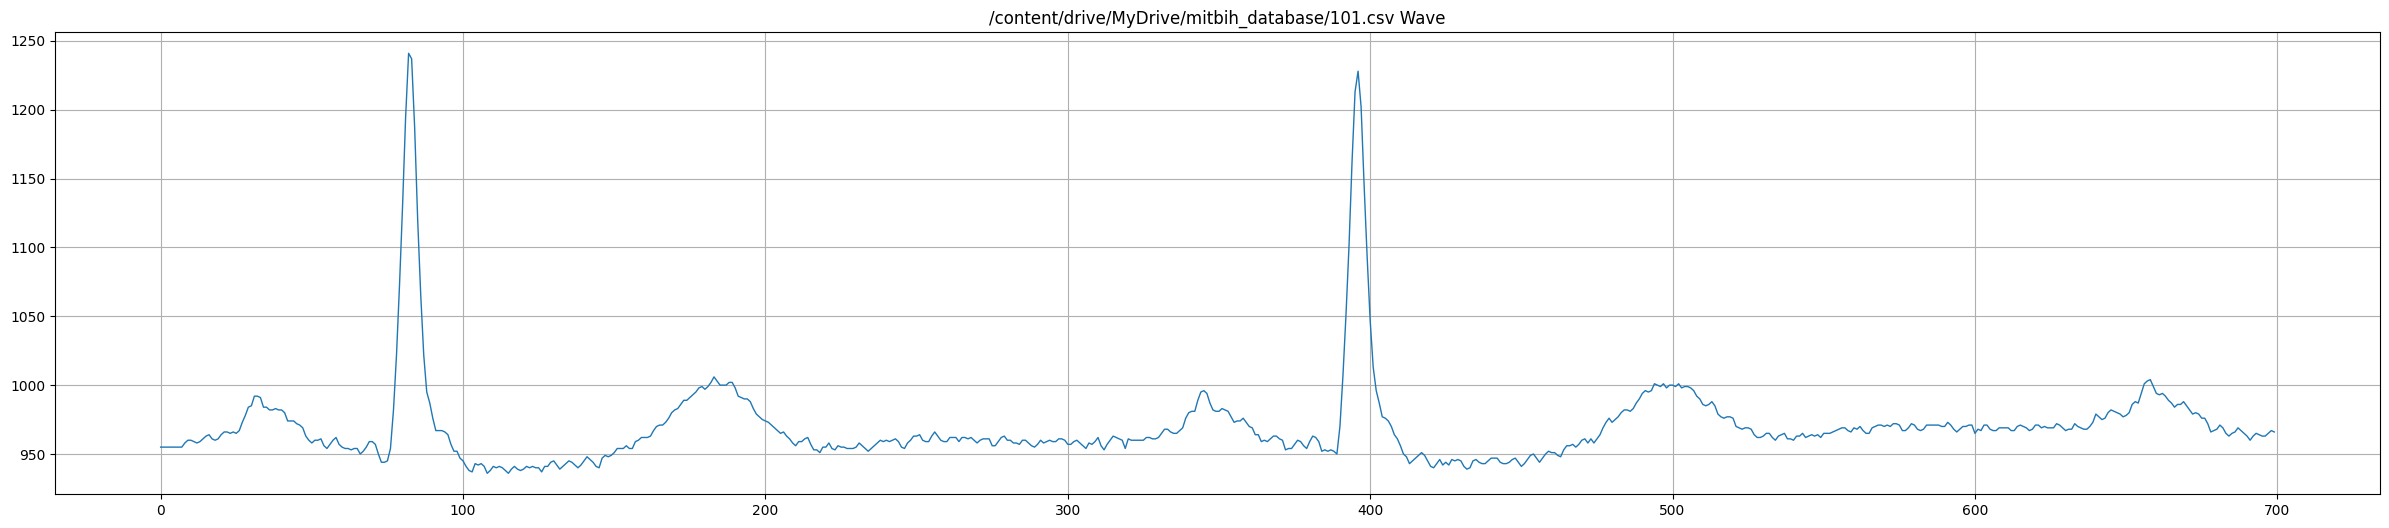

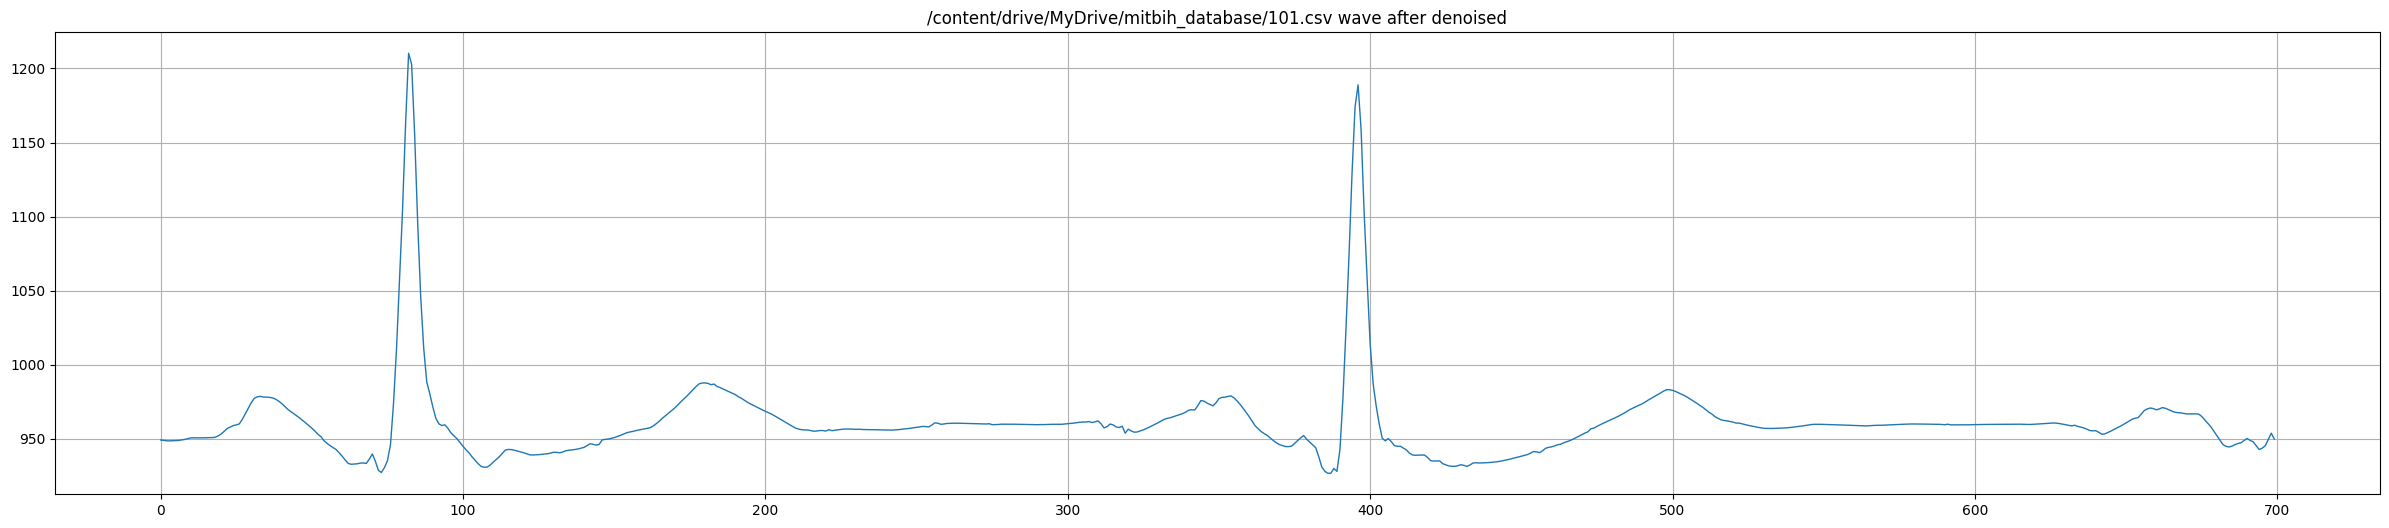

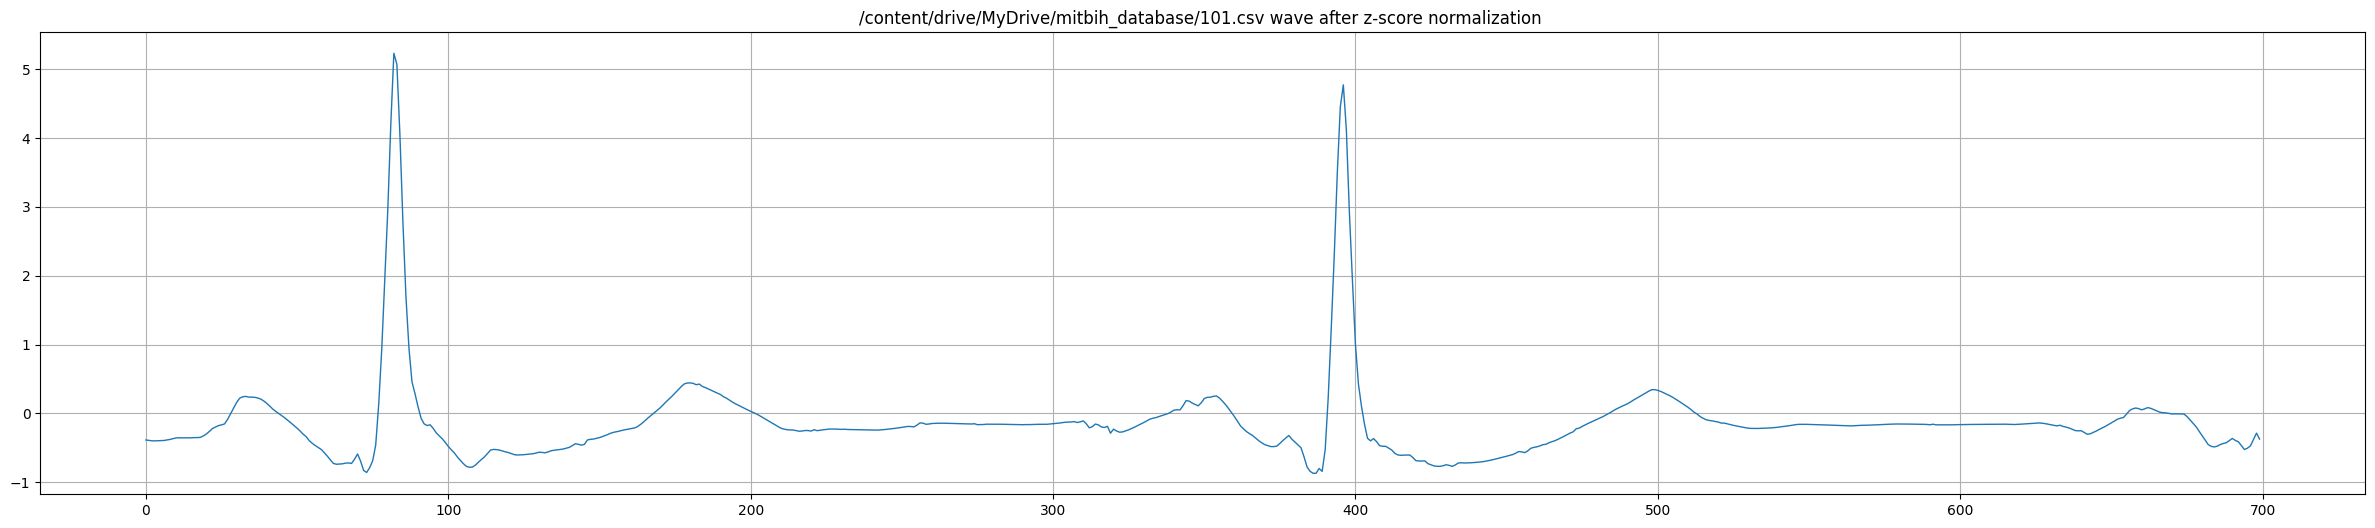

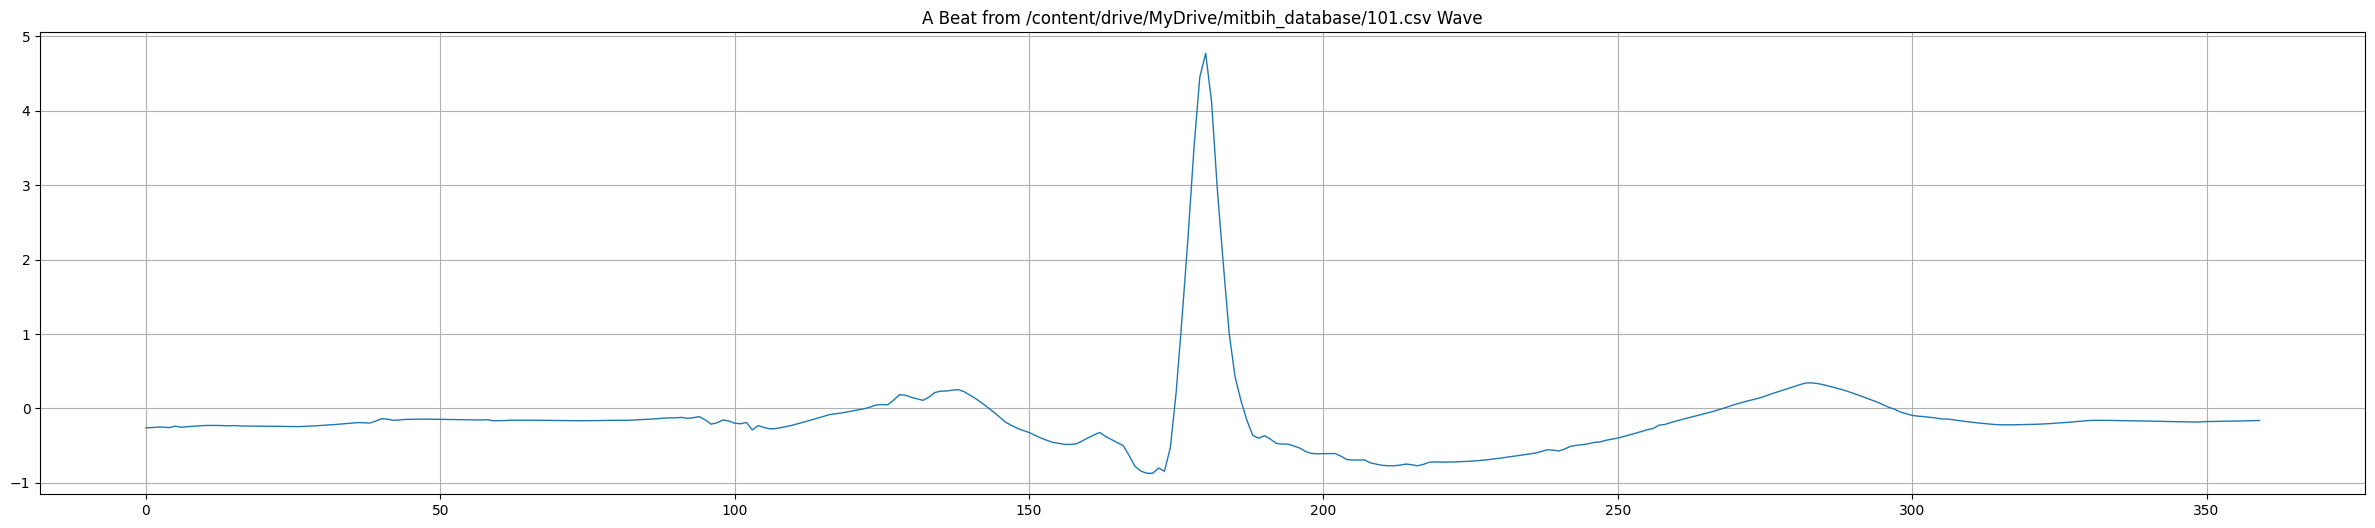

(100012, 360) (100012,)


In [ ]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    signals = denoise(signals)
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()

    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat
                    if r == 1 and not example_beat_printed:
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [ ]:
X_df=pd.DataFrame(X)
y_df=pd.DataFrame(y)
X_df[360]=y_df

In [ ]:
df_1=X_df[X_df[X_df.shape[1]-1]==1]
df_2=X_df[X_df[X_df.shape[1]-1]==2]
df_3=X_df[X_df[X_df.shape[1]-1]==3]
df_4=X_df[X_df[X_df.shape[1]-1]==4]
df_0=(X_df[X_df[X_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
X_df

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
77042,-1.680959,-1.659245,-1.633256,-1.602367,-1.570746,-1.537908,-1.501199,-1.463844,-1.432589,-1.403449,...,-0.991127,-0.991216,-0.988218,-0.984140,-0.978679,-0.972664,-0.966162,-0.958416,-0.950360,0
51230,-0.292774,-0.268355,-0.242973,-0.218719,-0.194505,-0.166678,-0.138870,-0.111956,-0.086613,-0.070647,...,-0.260494,-0.253279,-0.245243,-0.236866,-0.229991,-0.224125,-0.214610,-0.202842,-0.204465,0
46415,-0.245069,-0.247447,-0.241855,-0.221402,-0.199468,-0.201038,-0.193836,-0.250902,-0.225642,-0.176911,...,-0.148711,-0.126511,-0.142611,-0.161731,-0.153191,-0.192621,-0.153642,-0.106343,-0.131720,0
25690,-0.649717,-0.642706,-0.637089,-0.632181,-0.625337,-0.618411,-0.611368,-0.604798,-0.602013,-0.600907,...,-1.387854,-1.377446,-1.367678,-1.358452,-1.349109,-1.336963,-1.322018,-1.310993,-1.309391,0
32029,-0.174938,-0.170075,-0.183134,-0.166396,-0.176061,-0.163881,-0.164358,-0.154193,-0.155828,-0.144012,...,-0.126126,-0.129452,-0.130908,-0.136692,-0.135770,-0.126619,-0.155829,-0.140649,-0.127331,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62574,-0.295443,-0.282020,-0.314785,-0.304712,-0.316547,-0.325500,-0.333263,-0.342388,-0.337477,-0.352993,...,-0.152430,-0.154993,-0.159247,-0.165455,-0.172687,-0.178794,-0.186440,-0.190297,-0.186199,4
43810,2.149784,1.750365,1.307845,0.681316,0.053408,-0.382085,-0.586079,-0.637357,-0.604070,-0.514104,...,0.183678,0.183915,0.180782,0.193172,0.184771,0.186667,0.186038,0.192884,0.187890,4
55926,-0.352329,-0.370749,-0.383749,-0.390506,-0.389582,-0.375241,-0.349470,-0.318251,-0.277177,-0.215388,...,-0.352375,-0.352186,-0.352419,-0.352507,-0.352714,-0.352508,-0.350232,-0.346941,-0.343195,4
79930,4.631876,5.216779,5.563217,5.468084,4.828041,3.808149,2.605932,1.371079,0.249672,-0.487296,...,0.215189,0.213954,0.218124,0.233903,0.189475,0.205103,0.225428,0.257264,0.241486,4


train test split

In [ ]:
y_df2=X_df[360]
X_df2=X_df.drop(columns=[360])

In [ ]:
y_df2=y_df2.to_numpy()
X_df2=X_df2.to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_df2, y_df2, test_size=0.2, random_state=42,stratify=y_df2)

In [ ]:
# Reshape the input data for PyTorch (add channel dimension)
X_train = X_train.reshape((-1, 1, 360))
X_test = X_test.reshape((-1, 1, 360))

In [ ]:
np.shape(X_train)

(20000, 1, 360)

prepare dataset & dataloader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
# Convert numpy arrays to PyTorch tensors and move to the GPU
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

In [ ]:
# Create dataloaders for batching the data
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:

# # https://blog.paperspace.com/alexnet-pytorch/
# import torch
# import torch.nn as nn
# import torch
# import torch.nn as nn

# class AlexNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(AlexNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv1d(1, 32, kernel_size=1, stride=4),
#             # , padding=0),
#             nn.BatchNorm2d(96),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=3, stride=2))
#         self.layer2 = nn.Sequential(
#             nn.Conv1d(32, 256, kernel_size=5, stride=1),
#             # , padding=2),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2))
#         self.layer3 = nn.Sequential(
#             nn.Conv1d(256, 384, kernel_size=3, stride=1),
#             # , padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer4 = nn.Sequential(
#             nn.Conv1d(384, 384, kernel_size=3, stride=1),
#             # , padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer5 = nn.Sequential(
#             nn.Conv1d(384, 256, kernel_size=3, stride=1),
#             # , padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2))
#         self.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(9216, 4096),
#             nn.ReLU())
#         self.fc1 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU())
#         self.fc2 = nn.Linear(4096, num_classes)

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         return out
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(384, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(384, 256, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool1d(6)
        self.classifier = nn.Sequential(
            nn.Dropo  ut(0.5),
            nn.Linear(256 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
model = AlexNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_inputs, batch_labels in train_dataloader:
        optimizer.zero_grad()
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        # batch_inputs = batch_inputs.unsqueeze(0)
        batch_outputs = model(batch_inputs)
        loss = criterion(batch_outputs, batch_labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_inputs.size(0)
    train_loss /= len(train_dataloader.dataset)

    # Evaluation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0.0
        for batch_inputs, batch_labels in test_dataloader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            batch_outputs = model(batch_inputs)

            # Calculate loss and accuracy
            loss = criterion(batch_outputs, batch_labels)
            test_loss += loss.item() * batch_inputs.size(0)

            _, predicted = torch.max(batch_outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

        test_loss /= len(test_dataloader.dataset)
        test_accuracy = correct / total

    # Print the epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2%}")
    print()

Epoch 1/50:
Train Loss: 0.4022
Test Loss: 0.2493
Test Accuracy: 92.98%

Epoch 2/50:
Train Loss: 0.1767
Test Loss: 0.1345
Test Accuracy: 95.22%

Epoch 3/50:
Train Loss: 0.1401
Test Loss: 0.1647
Test Accuracy: 94.88%

Epoch 4/50:
Train Loss: 0.1166
Test Loss: 0.0953
Test Accuracy: 96.58%

Epoch 5/50:
Train Loss: 0.1179
Test Loss: 0.0731
Test Accuracy: 97.50%

Epoch 6/50:
Train Loss: 0.1007
Test Loss: 0.1347
Test Accuracy: 95.72%

Epoch 7/50:
Train Loss: 0.0942
Test Loss: 0.0663
Test Accuracy: 97.96%

Epoch 8/50:
Train Loss: 0.0873
Test Loss: 0.0893
Test Accuracy: 97.32%

Epoch 9/50:
Train Loss: 0.0730
Test Loss: 0.0872
Test Accuracy: 97.42%

Epoch 10/50:
Train Loss: 0.0794
Test Loss: 0.0640
Test Accuracy: 98.00%

Epoch 11/50:
Train Loss: 0.0709
Test Loss: 0.0701
Test Accuracy: 98.06%

Epoch 12/50:
Train Loss: 0.0721
Test Loss: 0.0575
Test Accuracy: 98.26%

Epoch 13/50:
Train Loss: 0.0679
Test Loss: 0.0513
Test Accuracy: 98.16%

Epoch 14/50:
Train Loss: 0.0675
Test Loss: 0.0620
Test Accur

model 1

In [ ]:
# Define the CNN model
class ECGClassifier(nn.Module):
    def __init__(self):
        super(ECGClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=13, padding=6, stride=1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=15, padding=7, stride=1)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=17, padding=8, stride=1)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(64, 128, kernel_size=19, padding=9, stride=1)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(2816, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, 5)  # 5 output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        return x

In [ ]:
class ECGClassifier2(nn.Module):
    def __init__(self):
        super(ECGClassifier2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=13, padding=6)
        self.relu1 = nn.ReLU()
        self.avgpool1 = nn.AvgPool1d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=15, padding=7)
        self.relu2 = nn.ReLU()
        self.avgpool2 = nn.AvgPool1d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=17, padding=8)
        self.relu3 = nn.ReLU()
        self.avgpool3 = nn.AvgPool1d(kernel_size=3, stride=2)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=19, padding=9)
        self.relu4 = nn.ReLU()
        self.avgpool4 = nn.AvgPool1d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(2688, 35)
        self.dense2 = nn.Linear(35, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avgpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.avgpool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.avgpool4(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

add LSTM attention

In [ ]:
class ECGClassifier3(nn.Module):
    def __init__(self):
        super(ECGClassifier3, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=13, padding=6, stride=1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=15, padding=7, stride=1)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=17, padding=8, stride=1)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(64, 128, kernel_size=19, padding=9, stride=1)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(128, 64, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(64 * 2, 1)

        self.fc1 = nn.Linear(64 * 2, 128)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(128, 5)  # 5 output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        # LSTM layer
        x, _ = self.lstm(x.transpose(1, 2))

        # Attention mechanism
        attention_weights = F.softmax(self.attention(x), dim=1)
        x = torch.sum(x * attention_weights, dim=1)

        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        return x

train model

In [ ]:
model = ECGClassifier3().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_inputs, batch_labels in train_dataloader:
        optimizer.zero_grad()
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        batch_outputs = model(batch_inputs)
        loss = criterion(batch_outputs, batch_labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_inputs.size(0)
    train_loss /= len(train_dataloader.dataset)

    # Evaluation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0.0
        for batch_inputs, batch_labels in test_dataloader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            batch_outputs = model(batch_inputs)

            # Calculate loss and accuracy
            loss = criterion(batch_outputs, batch_labels)
            test_loss += loss.item() * batch_inputs.size(0)

            _, predicted = torch.max(batch_outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

        test_loss /= len(test_dataloader.dataset)
        test_accuracy = correct / total

    # Print the epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2%}")
    print()

Epoch 1/50:
Train Loss: 0.3088
Test Loss: 0.1144
Test Accuracy: 96.08%

Epoch 2/50:
Train Loss: 0.1104
Test Loss: 0.1096
Test Accuracy: 96.12%

Epoch 3/50:
Train Loss: 0.0828
Test Loss: 0.0727
Test Accuracy: 97.56%

Epoch 4/50:
Train Loss: 0.0666
Test Loss: 0.0712
Test Accuracy: 97.42%

Epoch 5/50:
Train Loss: 0.0576
Test Loss: 0.0512
Test Accuracy: 98.14%

Epoch 6/50:
Train Loss: 0.0494
Test Loss: 0.0797
Test Accuracy: 97.34%

Epoch 7/50:
Train Loss: 0.0459
Test Loss: 0.0519
Test Accuracy: 98.26%

Epoch 8/50:
Train Loss: 0.0394
Test Loss: 0.0464
Test Accuracy: 98.44%

Epoch 9/50:
Train Loss: 0.0366
Test Loss: 0.0370
Test Accuracy: 98.72%

Epoch 10/50:
Train Loss: 0.0252
Test Loss: 0.0432
Test Accuracy: 98.56%

Epoch 11/50:
Train Loss: 0.0320
Test Loss: 0.0364
Test Accuracy: 98.62%

Epoch 12/50:
Train Loss: 0.0224
Test Loss: 0.0346
Test Accuracy: 98.76%

Epoch 13/50:
Train Loss: 0.0209
Test Loss: 0.0429
Test Accuracy: 98.62%

Epoch 14/50:
Train Loss: 0.0217
Test Loss: 0.0329
Test Accur